# EN3160 Assignment 2 on Fitting and Alignment

## Task 1


Detected Largest Circle Parameters:
Radius: 22.627416997969537
Center Coordinates: (167, 340)

Sigma Value Range:
Minimum Sigma: 0.5
Maximum Sigma: 64.00000000000006


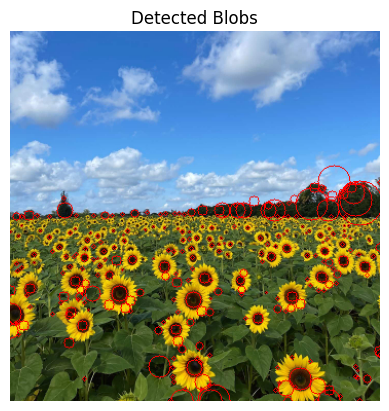

In [112]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the Laplacian of Gaussian (LoG) kernel
def generate_log_filter(sigma, filter_size):
        hw = int(3 * sigma + 1)  # Ensure hw is an integer
        x = np.linspace(-hw, hw, 2 * hw + 1)  # Generate evenly spaced values for x
        y = np.linspace(-hw, hw, 2 * hw + 1)  # Generate evenly spaced values for y

        X, Y = np.meshgrid(x, y)  # Create a meshgrid of X and Y coordinates
        temp = -(X**2 + Y**2) / (2 * sigma**2)  # Compute the exponent term
        gauss_kernel = np.exp(temp)  # Compute Gaussian kernel
        gauss_kernel[gauss_kernel < np.finfo(float).eps * np.amax(gauss_kernel)] = 0  # Eliminate small values
        
        if np.sum(gauss_kernel) != 0:
            gauss_kernel /= np.sum(gauss_kernel)  # Normalize the kernel

        log_filter = (X**2 + Y**2 - 2 * sigma**2) * gauss_kernel / (sigma**4)  # Compute the LoG filter

        return log_filter



# Read image
image = cv.imread("the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)

# Convert image to grayscale and normalize
grayscale_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convert to grayscale
grayscale_img = np.float32(grayscale_img)  # Convert to float32
cv.normalize(grayscale_img, grayscale_img, 1, 0, cv.NORM_MINMAX)  # Normalize grayscale image

# Set parameters for the LoG scale-space
initial_sigma = 0.5 # Initial sigma value
scale_factor = np.sqrt(2)  # Scaling factor between subsequent layers
num_layers = 15  # Number of scales
sigma_values = initial_sigma * np.power(scale_factor, np.arange(num_layers))  # List of sigma values for each scale

# Perform LoG filtering at different scales
image_stack = None

for scale in range(num_layers):
        filter_size = int(2 * np.ceil(4 * sigma_values[scale]) + 1)  # Compute filter size for each scale

        log_filter = generate_log_filter(sigma_values[scale], filter_size) * np.power(sigma_values[scale], 2)  # Generate LoG filter
        filtered_img = cv.filter2D(grayscale_img, cv.CV_32F, log_filter)  # Apply LoG filter
        filtered_img = pow(filtered_img, 2)  # Square the filtered image to enhance contrast
        
        # Stack filtered images
        if scale == 0:
                image_stack = filtered_img
        else:
                image_stack = np.dstack((image_stack, filtered_img)) 

# Extract the maximum response from the filtered images
max_response_space = None 

for scale in range(num_layers):
        filtered_max = cv.dilate(image_stack[:, :, scale], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT)  # Dilate filtered images
        
        if scale == 0:
                max_response_space = filtered_max
        else:
                max_response_space = np.dstack((max_response_space, filtered_max))

# Identify the maximum response across all scales
max_response_stack = np.amax(max_response_space, axis=2)  # Max across all scales
max_response_stack = np.repeat(max_response_stack[:, :, np.newaxis], num_layers, axis=2)  # Repeat for each scale
max_response_stack = np.multiply((max_response_stack == max_response_space), max_response_space)  # Retain only maximum responses

# Initialize vectors to store circle properties
radius_vector = None
x_coords = None
y_coords = None

for scale in range(num_layers):
        current_radius = np.sqrt(2) * sigma_values[scale]  # Calculate radius for current scale
        response_threshold = 0.02  # Threshold for maximum response
        valid_responses = (max_response_stack[:, :, scale] == image_stack[:, :, scale]) * image_stack[:, :, scale]  # Retain valid maximum responses
        valid_responses[valid_responses <= response_threshold] = 0  # Remove weak responses
        (x_points, y_points) = np.nonzero(valid_responses)  # Get coordinates of valid points
        
        if scale == 1:
                x_coords = x_points
                y_coords = y_points
                radius_vector = np.repeat(current_radius, np.size(x_points))  # Set radius vector for initial points
        else:
                x_coords = np.concatenate((x_coords, x_points), axis=None)
                y_coords = np.concatenate((y_coords, y_points), axis=None)
                radius_vector = np.concatenate((radius_vector, np.repeat(current_radius, np.size(x_points))), axis=None)

# Find the parameters of the largest detected circle
largest_radius = np.max(radius_vector)
largest_circle_idx = np.argmax(radius_vector)
largest_x = x_coords[largest_circle_idx]
largest_y = y_coords[largest_circle_idx]

# Report the parameters of the largest detected circle
print("\nDetected Largest Circle Parameters:")
print(f"Radius: {largest_radius}")
print(f"Center Coordinates: ({largest_x}, {largest_y})")

# Display the range of sigma values used
min_sigma_value = np.min(sigma_values)
max_sigma_value = np.max(sigma_values)
print(f"\nSigma Value Range:")
print(f"Minimum Sigma: {min_sigma_value}")
print(f"Maximum Sigma: {max_sigma_value}")

# Visualize the detected blobs (circles) on the image
output_image = image.copy()

for i in range(np.size(x_coords)):
       cv.circle(output_image, (y_coords[i], x_coords[i]), int(radius_vector[i]), (0, 0, 255), 1) 

# Display result using Matplotlib
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.title("Detected Blobs")
plt.axis('off')
plt.show()


## Task 2

## Task 3

In [ ]:
#code

## Task 4

In [ ]:
#code